In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

random_state=7

%matplotlib inline
pd.set_option('display.max_columns', 500)

# Reading Data

In [2]:
train=pd.read_csv('input/train.csv', parse_dates=['timestamp'])
test=pd.read_csv('input/test.csv', parse_dates=['timestamp'])
macro=pd.read_csv('input/macro.csv', parse_dates=['timestamp'])

test_id=test['id']

print('The shape of training data is', train.shape)
print('The shape of test data is', test.shape)
print('The shape of macro data is', macro.shape)


#fts contains the feature names (exclude id and year)
fts=list(train.columns[1:-1])

The shape of training data is (30471, 292)
The shape of test data is (7662, 291)
The shape of macro data is (2484, 100)


In [3]:
trainsub=train[train.timestamp<'2015-01-01']
trainsub=trainsub[trainsub.product_type=='Investment']
print('shape of the investment type', trainsub.shape)

ind_1m=trainsub[trainsub.price_doc <= 1000000].index
ind_2m=trainsub[trainsub.price_doc == 2000000].index
ind_3m=trainsub[trainsub.price_doc==3000000].index

print('num of ind_1m', len(ind_1m))
print('num of ind_2m', len(ind_2m))
print('num of ind_3m', len(ind_3m))

train_index=set(train.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set=set(ind)
    ind_set_cut=ind.difference(set(ind[::gap]))
    
    train_index=train_index.difference(ind_set_cut)
    
train=train.loc[train_index]

target=np.log(train.price_doc+1)
#number of training and test example
n_train=train.shape[0]
n_test=test.shape[0]

shape of the investment type (17693, 292)
num of ind_1m 930
num of ind_2m 680
num of ind_3m 292


# Combine train and test and Change Categorical Data to Dummies

In [4]:
#concatenate training and test
raw_data=pd.concat([train.loc[:,fts[0]:fts[-1]], test.loc[:, fts[0]:fts[-1]]])
print('shape of train plus test', raw_data.shape)

macro_dtypes=macro.dtypes
print(macro_dtypes[macro_dtypes=='object'])

shape of train plus test (36697, 290)
child_on_acc_pre_school      object
modern_education_share       object
old_education_build_share    object
dtype: object


In [5]:
#join the macro data
raw_data=pd.merge(raw_data, macro, how='left', on='timestamp')
print('shape of the merged data', raw_data.shape)

shape of the merged data (36697, 389)


In [6]:
data=pd.get_dummies(raw_data)
print('shape after get_dummies', data.shape)

#change timestamp to year
data['timestamp']=data['timestamp'].dt.year.astype(int)

shape after get_dummies (36697, 557)


# Fill NaN with median values

In [7]:
#when using get_dummies the Nan in categorical data are ignored. The possible Nan are numbers. fill them with mean
print('number of NaN in train and test', data.isnull().sum().sum())

data=data.fillna(-1000)

print('number of NaN in train and test', data.isnull().sum().sum())

number of NaN in train and test 916718
number of NaN in train and test 0


# Try standardscaler before fitting

In [8]:
from sklearn.preprocessing import StandardScaler
col_names=list(data.columns)

ss=StandardScaler(with_mean=False, with_std=True)
data_std=ss.fit_transform(data)
data_std=pd.DataFrame(data_std, columns=col_names)

train_std=data_std.iloc[:n_train, :]
test_std=data_std.iloc[n_train :, :]

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

clf1=RandomForestRegressor(n_estimators=500, random_state=random_state)
clf1.fit(train_std, target)

In [ ]:
pre_rf=clf1.predict(test_std)
pre_rf=np.exp(pre_rf)+1

#test_id=np.array(test_id)
#submission=pd.DataFrame({'id': test_id, 'price_doc': pre_rf})
#submission.to_csv(path_or_buf='170517submission_randomforest_with_macro_data.csv',index=False)
#submission.head()

# XGBOOST

In [9]:
import xgboost as xgb

/home/xinlin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
from sklearn.model_selection import train_test_split
train_part, val_train, target_part, val_target=train_test_split(train_std, target, test_size=0.2, 
                                                              random_state=random_state)
print('shape of train_part', train_part.shape)
print('shape of target_part', target_part.shape)
print('shape of val_train', val_train.shape)
print('shape of val_target', val_target.shape)

shape of train_part (23228, 557)
shape of target_part (23228,)
shape of val_train (5807, 557)
shape of val_target (5807,)


In [24]:
#find relative importance features using xgb
dtrain=xgb.DMatrix(train_part, target_part)
dval=xgb.DMatrix(val_train, val_target)
dtest=xgb.DMatrix(test_std)

xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'labmda':100,
    'silent': 0,
    'base_score': 7
}

model=xgb.train(xgb_params, dtrain, num_boost_round=2000, 
                evals=[(dval, 'validation')], early_stopping_rounds=20,
               verbose_eval=20)
num_boost_round=model.best_iteration

[0]	validation-rmse:8.52182
Will train until validation-rmse hasn't improved in 20 rounds.
[20]	validation-rmse:5.69713
[40]	validation-rmse:3.81386
[60]	validation-rmse:2.56079
[80]	validation-rmse:1.72997
[100]	validation-rmse:1.18323
[120]	validation-rmse:0.829465
[140]	validation-rmse:0.607452
[160]	validation-rmse:0.475474
[180]	validation-rmse:0.402016
[200]	validation-rmse:0.363783
[220]	validation-rmse:0.344848
[240]	validation-rmse:0.335385
[260]	validation-rmse:0.330593
[280]	validation-rmse:0.328078
[300]	validation-rmse:0.326585
[320]	validation-rmse:0.325732
[340]	validation-rmse:0.325074
[360]	validation-rmse:0.324637
[380]	validation-rmse:0.324278
[400]	validation-rmse:0.323911
[420]	validation-rmse:0.323775
[440]	validation-rmse:0.323569
[460]	validation-rmse:0.323415
[480]	validation-rmse:0.323282
[500]	validation-rmse:0.323065
[520]	validation-rmse:0.322867
[540]	validation-rmse:0.322587
[560]	validation-rmse:0.322563
[580]	validation-rmse:0.322386
[600]	validation-rm

In [25]:
import operator
score=model.get_fscore()
score=sorted(score.items(), key=operator.itemgetter(1), reverse=True)
score=pd.DataFrame(score, columns=['feature', 'fscore'])

importance_rate=0.01
f_index=score[score.fscore>importance_rate*score.fscore.max()].feature
print('number of important features', len(f_index))
df_f_index=pd.DataFrame(f_index)
df_f_index.to_csv(path_or_buf='features_importance_rate_0.01_withallmacro')

number of important features 208


In [26]:
train_select=pd.DataFrame(train_part)
train_select=train_select[f_index]

val_select=pd.DataFrame(val_train)
val_select=val_select[f_index]

dtrain_select=xgb.DMatrix(train_select, target_part)
dval_select=xgb.DMatrix(val_select, val_target)

xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'lambda':100,
    'base_score':7
}

model=xgb.train(xgb_params, dtrain_select, num_boost_round=2000, 
                evals=[(dval_select, 'validation')], early_stopping_rounds=20,
               verbose_eval=20)
num_boost_round=model.best_iteration

[0]	validation-rmse:8.52292
Will train until validation-rmse hasn't improved in 20 rounds.
[20]	validation-rmse:5.71415
[40]	validation-rmse:3.84135
[60]	validation-rmse:2.59719
[80]	validation-rmse:1.77336
[100]	validation-rmse:1.23073
[120]	validation-rmse:0.877964
[140]	validation-rmse:0.653389
[160]	validation-rmse:0.515217
[180]	validation-rmse:0.434398
[200]	validation-rmse:0.388521
[220]	validation-rmse:0.363246
[240]	validation-rmse:0.349167
[260]	validation-rmse:0.340985
[280]	validation-rmse:0.336181
[300]	validation-rmse:0.333206
[320]	validation-rmse:0.331174
[340]	validation-rmse:0.329702
[360]	validation-rmse:0.328513
[380]	validation-rmse:0.327669
[400]	validation-rmse:0.326764
[420]	validation-rmse:0.326078
[440]	validation-rmse:0.325489
[460]	validation-rmse:0.324998
[480]	validation-rmse:0.324555
[500]	validation-rmse:0.324251
[520]	validation-rmse:0.32393
[540]	validation-rmse:0.323684
[560]	validation-rmse:0.323401
[580]	validation-rmse:0.323179
[600]	validation-rms

In [27]:
Ddata_std=xgb.DMatrix(train_std[f_index], target)

In [28]:
#use xgb.cv to do cross validation
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'lambda': 100,
    'base_score': 7
}

cv_results=xgb.cv(xgb_params, Ddata_std, num_boost_round=3000, 
       nfold=5, verbose_eval=50, early_stopping_rounds=20)

[0]	train-rmse:8.52532+0.00100574	test-rmse:8.52532+0.00412476
[50]	train-rmse:3.15761+0.000312647	test-rmse:3.15761+0.00481429


KeyboardInterrupt: 

In [29]:
full_model=xgb.train(xgb_params, Ddata_std, num_boost_round=num_boost_round)

(array([   39.,    88.,   897.,  2788.,  2477.,  1022.,   247.,    66.,
           28.,    10.]),
 array([ 14.31025505,  14.63928471,  14.96831436,  15.29734402,
         15.62637367,  15.95540333,  16.28443298,  16.61346264,
         16.94249229,  17.27152195,  17.60055161]),
 <a list of 10 Patch objects>)

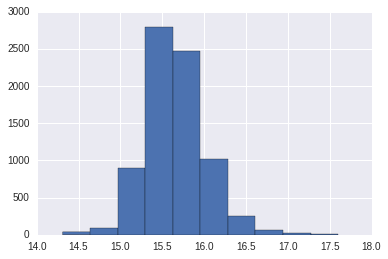

In [30]:
dtest_select=xgb.DMatrix(test_std[f_index])
pre_xgb=full_model.predict(dtest_select)

plt.hist(pre_xgb)

In [31]:
pre_xgb=np.exp(pre_xgb)-1

submission=pd.DataFrame({'id': test_id, 'price_doc': pre_xgb})
submission.to_csv(path_or_buf='170520submission_xgb_with_all_macro_xgbimportance0.01_lambda_100_base_score_7.csv',index=False)
submission.head()

,id,price_doc
0,30474,5531034.5
1,30475,8743247.0
2,30476,5205453.5
3,30477,6277257.5
4,30478,5298138.5


# GBRT

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

clf=GradientBoostingRegressor(n_estimators=500,max_depth=5, 
                              verbose=1, random_state=random_state)

In [37]:
GBRT_params={
    'learning_rate': [0.03],
    'n_estimators': [300],
    'subsample': [0.8],
    'max_depth': [None],
    'max_leaf_nodes': [9]
    
}

cv=GridSearchCV(clf, GBRT_params, cv=5, verbose=5)
cv.fit(train_std[f_index], target)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=300, max_leaf_nodes=9, max_depth=None, learning_rate=0.03, subsample=0.8 
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2522           0.0074            4.24m
         2           0.2424           0.0070            4.28m
         3           0.2351           0.0068            4.33m
         4           0.2327           0.0062            4.34m
         5           0.2259           0.0059            4.29m
         6           0.2188           0.0053            4.29m
         7           0.2138           0.0051            4.26m
         8           0.2073           0.0050            4.26m
         9           0.2038           0.0048            4.24m
        10           0.1985           0.0043            4.24m
        20           0.1648           0.0027            4.91m
        30           0.1454           0.0017            5.07m
        40           0.1313           0.00

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2631           0.0069            4.83m
         2           0.2531           0.0066            4.78m
         3           0.2468           0.0065            4.70m
         4           0.2441           0.0061            4.62m
         5           0.2354           0.0057            4.64m
         6           0.2310           0.0050            4.61m
         7           0.2238           0.0049            4.61m
         8           0.2196           0.0048            4.57m
         9           0.2156           0.0046            4.56m
        10           0.2119           0.0042            4.55m
        20           0.1786           0.0028            5.44m
        30           0.1593           0.0016            5.73m
        40           0.1461           0.0010            5.43m
        50           0.1367           0.0006            5.22m
        60           0.1304           0.0005            4.98m
       

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.6min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2580           0.0070            4.86m
         2           0.2483           0.0067            6.74m
         3           0.2429           0.0064            6.61m
         4           0.2396           0.0059            6.20m
         5           0.2301           0.0056            6.36m
         6           0.2274           0.0051            6.21m
         7           0.2199           0.0049            6.11m
         8           0.2145           0.0048            6.27m
         9           0.2095           0.0046            6.09m
        10           0.2048           0.0042            5.96m
        20           0.1748           0.0026            5.52m
        30           0.1553           0.0015            5.65m
        40           0.1420           0.0009            5.56m
        50           0.1324           0.0006            5.49m
        60           0.1249           0.0005            5.25m
       

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.5min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2531           0.0067            5.68m
         2           0.2444           0.0065            5.77m
         3           0.2383           0.0064            5.82m
         4           0.2356           0.0058            6.30m
         5           0.2271           0.0054            6.19m
         6           0.2256           0.0052            6.10m
         7           0.2197           0.0048            6.18m
         8           0.2121           0.0047            6.12m
         9           0.2101           0.0044            6.05m
        10           0.2036           0.0041            5.91m
        20           0.1752           0.0025            5.14m
        30           0.1554           0.0015            5.03m
        40           0.1435           0.0009            4.59m
        50           0.1342           0.0007            4.32m
        60           0.1263           0.0004            4.06m
       

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.5min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2436           0.0065            8.90m
         2           0.2346           0.0065            7.08m
         3           0.2253           0.0065            6.94m
         4           0.2241           0.0059            6.86m
         5           0.2149           0.0054            7.38m
         6           0.2162           0.0051            7.76m
         7           0.2086           0.0048            7.58m
         8           0.2032           0.0047            7.44m
         9           0.1997           0.0044            7.75m
        10           0.1950           0.0039            7.92m
        20           0.1655           0.0025            6.53m
        30           0.1446           0.0015            6.07m
        40           0.1336           0.0009            5.67m
        50           0.1250           0.0007            5.15m
        60           0.1183           0.0004            4.93m
       

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 26.3min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2537           0.0067            7.04m
         2           0.2460           0.0063            6.84m
         3           0.2381           0.0063            6.78m
         4           0.2355           0.0057            6.73m
         5           0.2284           0.0056            6.65m
         6           0.2226           0.0053            6.64m
         7           0.2176           0.0049            6.68m
         8           0.2138           0.0048            6.67m
         9           0.2084           0.0045            6.62m
        10           0.2043           0.0043            6.59m
        20           0.1720           0.0024            6.62m
        30           0.1535           0.0015            6.75m
        40           0.1407           0.0010            6.34m
        50           0.1336           0.0007            6.04m
        60           0.1280           0.0005            5.72m
       

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=7, subsample=1.0, verbose=1,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [9], 'n_estimators': [300], 'subsample': [0.8], 'learning_rate': [0.03], 'max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=5)

In [38]:
cv.cv_results_

{'mean_fit_time': array([ 313.22879701]),
 'mean_score_time': array([ 0.38837142]),
 'mean_test_score': array([ 0.57250171]),
 'mean_train_score': array([ 0.6376275]),
 'param_learning_rate': masked_array(data = [0.03],
              mask = [False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [None],
              mask = [False],
        fill_value = ?),
 'param_max_leaf_nodes': masked_array(data = [9],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300],
              mask = [False],
        fill_value = ?),
 'param_subsample': masked_array(data = [0.8],
              mask = [False],
        fill_value = ?),
 'params': ({'learning_rate': 0.03,
   'max_depth': None,
   'max_leaf_nodes': 9,
   'n_estimators': 300,
   'subsample': 0.8},),
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([ 0.44259082]),
 'split0_train_score': array([ 0.6615174]),
 'split1_test_score': array([ 0.624792]),
 'spl

(array([   85.,   406.,  1468.,  2687.,  1796.,   847.,   240.,    87.,
           36.,    10.]),
 array([ 14.62562779,  14.9167267 ,  15.20782561,  15.49892453,
         15.79002344,  16.08112235,  16.37222127,  16.66332018,
         16.9544191 ,  17.24551801,  17.53661692]),
 <a list of 10 Patch objects>)

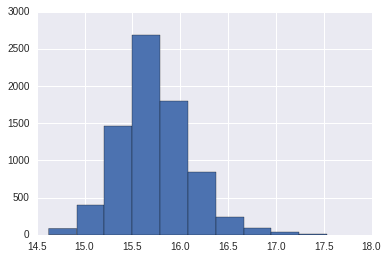

In [42]:
pre_GBRT=cv.predict(test_std[f_index])
plt.hist(pre_GBRT)

In [43]:
pre_GBRT=np.exp(pre_GBRT)-1

submission=pd.DataFrame({'id': test_id, 'price_doc': pre_GBRT})
submission.to_csv(path_or_buf='170521submission_GBRT_with_12features_macro_xgbimportance0.01_maxnodes_9_nestima_300_eta_0.03.csv',index=False)
submission.head()

,id,price_doc
0,30474,5491523.286355
1,30475,8162187.659420
2,30476,5791887.366958
3,30477,5699392.888169
4,30478,5034656.119083


In [56]:
#average the xgboost results and GBRT results
pre_ave=(pre_xgb+pre_GBRT)/2

submission=pd.DataFrame({'id': test_id, 'price_doc': pre_ave})
submission.to_csv(path_or_buf='170521submission_GBRT_xgb_ave_with_12features_macro_xgbimportance0.01.csv',index=False)
submission.head()

,id,price_doc
0,30474,5602817.893177
1,30475,8554147.329710
2,30476,5604879.433479
3,30477,5923494.194085
4,30478,5165381.809541
